<h1 style="text-align: center;">Final Project</h1>
<h2 style="text-align: center;">02807 Computational Tools for Data Science</h2>
<p style="text-align: center;">Authors: s241645, s242689, s253167, s253095</p>

In [96]:
# Import necessary packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import pathlib
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from pathlib import Path
import os
from typing import List, Tuple, Union
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import MiniBatchKMeans
from collections import namedtuple
from sklearn.preprocessing import StandardScaler, RobustScaler


In [130]:
# Read in the dataset 

df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [131]:
# We must scale the data 

# df = df.drop(df[df['Class'] == 1].index)
# df = df.drop(columns=['Class'])

# scaler = StandardScaler().fit(df)
# scaled_features = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# only keep the non-fraudulent transactions
df = df[df['Class'] == 0]

X = df.drop(columns=['Class'])

scaler = StandardScaler().fit(X)
scaled_features = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)



In [132]:
scaled_features.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,-1.997269,-0.708911,-0.040651,1.729567,0.990484,-0.253343,0.345865,0.195080,0.085841,0.329842,...,0.327600,-0.023819,0.383964,-0.177854,0.110183,0.247010,-0.391974,0.334763,-0.063483,0.245213
1,-1.997269,0.613324,0.166502,0.105733,0.325880,0.040211,-0.063748,-0.075024,0.074133,-0.238571,...,-0.088951,-0.313279,-0.882516,0.162851,-0.561311,0.321204,0.261247,-0.021728,0.045074,-0.342261
2,-1.997248,-0.708158,-0.815266,1.206665,0.277018,-0.374849,1.352031,0.663232,0.214128,-1.394495,...,0.683159,0.347730,1.066379,1.463047,-1.138150,-0.629129,-0.288253,-0.137697,-0.180906,1.160990
3,-1.997248,-0.504987,-0.109376,1.220221,-0.611315,-0.011616,0.935991,0.193392,0.325867,-1.277335,...,-0.269551,-0.149378,0.007321,-0.306320,-1.940913,1.243484,-0.460019,0.157606,0.186876,0.140777
4,-1.997227,-0.604459,0.540300,1.052843,0.293636,-0.304099,0.070308,0.494825,-0.232110,0.746553,...,0.531824,-0.011435,1.103135,-0.221269,0.232900,-0.395523,1.041766,0.549505,0.653229,-0.073173


In [135]:
# Our implementation of the K-means clustering algorithm.

def kmeans_implementation(df, k, max_iters=300, tol=0.0001, random_state=42):

    if random_state is not None:
        random.seed(random_state)
        np.random.seed(random_state)

    data = df.to_numpy()
    n_samples, n_features = data.shape

    # Randomly choose initial centroids
    indices = np.random.choice(n_samples, k, replace=False)
    centroids = data[indices, :]

    for iteration in range(max_iters):
        # Assign points to nearest centroid
        distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
        labels = np.argmin(distances, axis=1)

        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            points = data[labels == i]
            if len(points) > 0:
                new_centroids[i] = points.mean(axis=0)
            else:
                # Reinitialize empty cluster randomly
                new_centroids[i] = data[np.random.randint(0, n_samples)]

        # Check for convergence
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

        centroids = new_centroids

    return labels, centroids

Converged after 11 iterations.
k=2, DB score=4.6124
Converged after 25 iterations.
k=3, DB score=3.9964
Converged after 24 iterations.
k=4, DB score=3.7698
Converged after 28 iterations.
k=5, DB score=3.3322
Converged after 27 iterations.
k=6, DB score=3.2234
Converged after 21 iterations.
k=7, DB score=3.0898
Converged after 30 iterations.
k=8, DB score=2.6316
Converged after 35 iterations.
k=9, DB score=2.5996
Converged after 30 iterations.
k=10, DB score=2.3325


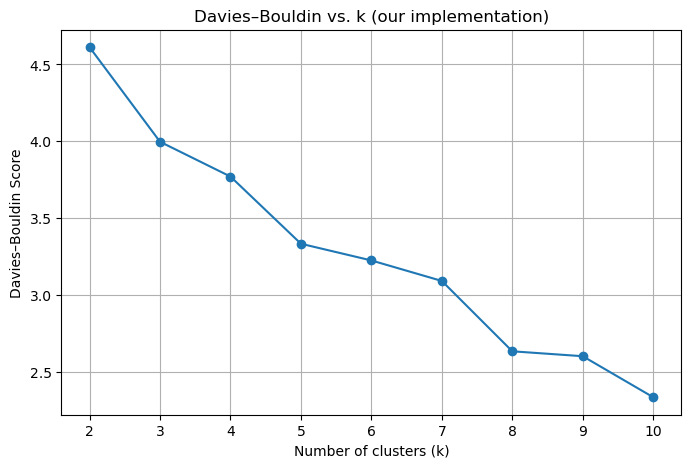

In [136]:
# Let's look at the Davies-Bouldin index for a few values of k

db_scores = []
k_values = list(range(2, 11))

for k in k_values:
    labels, centroids = kmeans_implementation(scaled_features,k)
    db = davies_bouldin_score(scaled_features, labels)
    db_scores.append(db)
    print(f"k={k}, DB score={db:.4f}")


plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Score")
plt.title("Davies–Bouldin vs. k (our implementation)")
plt.grid(True)
plt.show()

Converged after 11 iterations.
k=2, inertia=8234189.636632702
Converged after 25 iterations.
k=3, inertia=7972544.484540124
Converged after 24 iterations.
k=4, inertia=7734416.878331785
Converged after 28 iterations.
k=5, inertia=7462739.869694777
Converged after 27 iterations.
k=6, inertia=7360910.658215306
Converged after 21 iterations.
k=7, inertia=7247347.759703396
Converged after 30 iterations.
k=8, inertia=6952425.796450968
Converged after 35 iterations.
k=9, inertia=6758067.442257988
Converged after 30 iterations.
k=10, inertia=6558599.885307664


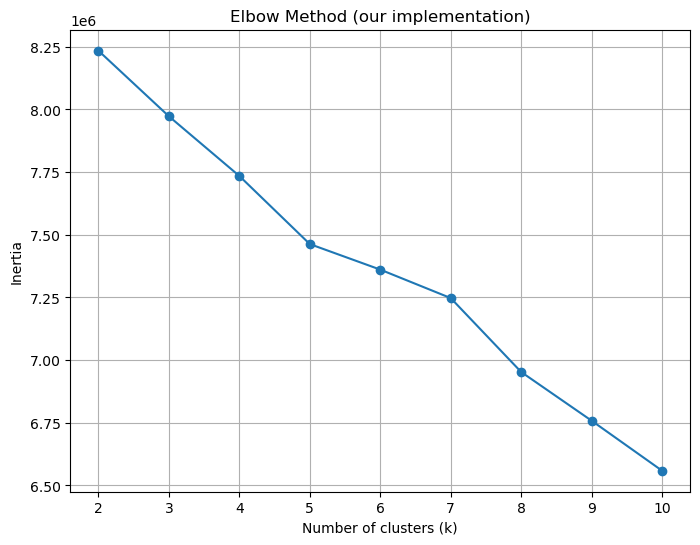

In [137]:
# Let's plot the elbow method to find the optimal k

def compute_inertia(df, labels, centroids):
    inertia = 0.0
    for i, p in enumerate(df.to_numpy()):
        c = centroids[labels[i]]
        inertia += np.sum((p - c) ** 2)
    return inertia

inertia_values = []
k_values = range(2, 11)   

for k in k_values:
    labels, centroids = kmeans_implementation(scaled_features, k)   
    inertia = compute_inertia(scaled_features, labels, centroids)
    inertia_values.append(inertia)
    print(f"k={k}, inertia={inertia}")

plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.title("Elbow Method (our implementation)")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


k=2, DB score=3.9077
k=3, DB score=3.2929
k=4, DB score=2.8235
k=5, DB score=2.7735
k=6, DB score=2.5035
k=7, DB score=2.7448
k=8, DB score=2.4158
k=9, DB score=2.3894
k=10, DB score=2.3637


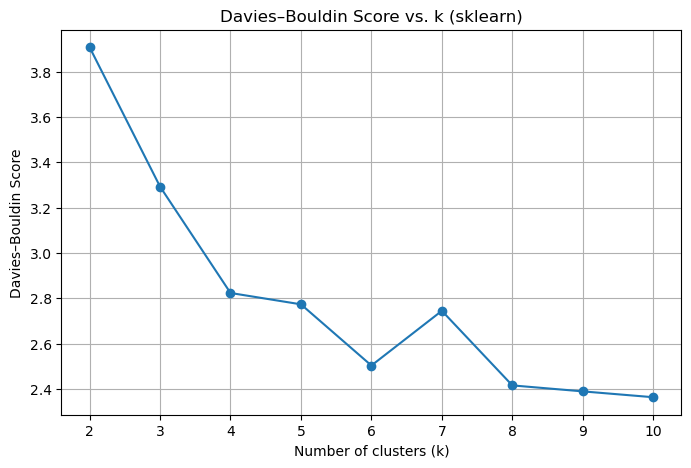

In [143]:
# Let's do the same using sklearn's KMeans

db_scores_sk = []

for k in k_values:
    kmeans = KMeans(n_clusters=k,random_state=42, n_init=10)
    labels_sklearn = kmeans.fit_predict(scaled_features)
    db = davies_bouldin_score(scaled_features, labels_sklearn)
    db_scores_sk.append(db)
    print(f"k={k}, DB score={db:.4f}")

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores_sk, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Davies–Bouldin Score")
plt.title("Davies–Bouldin Score vs. k (sklearn)")
plt.grid(True)
plt.show()

k=2, inertia=8209013.26
k=3, inertia=7836663.81
k=4, inertia=7607379.76
k=5, inertia=7483085.90
k=6, inertia=7174523.71
k=7, inertia=7071302.96
k=8, inertia=6991793.25
k=9, inertia=6873795.31
k=10, inertia=6736218.35


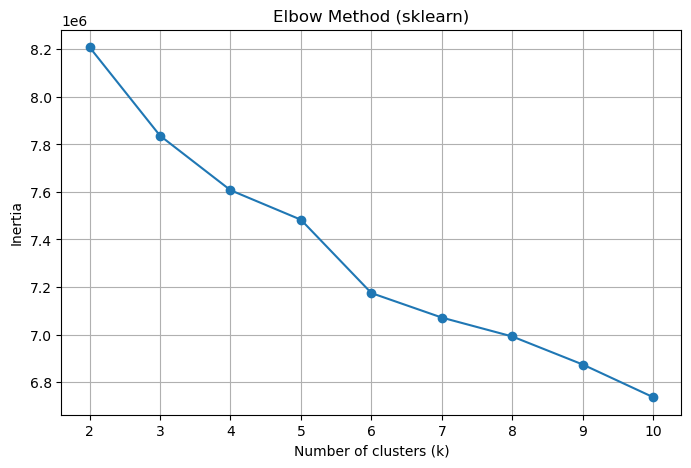

In [ ]:
# Elbow method using sklearn's KMeans

inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(scaled_features)
    inertia_values.append(kmeans.inertia_)
    print(f"k={k}, inertia={kmeans.inertia_:.2f}")

plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method (sklearn)")
plt.grid(True)
plt.show()

Converged after 28 iterations.


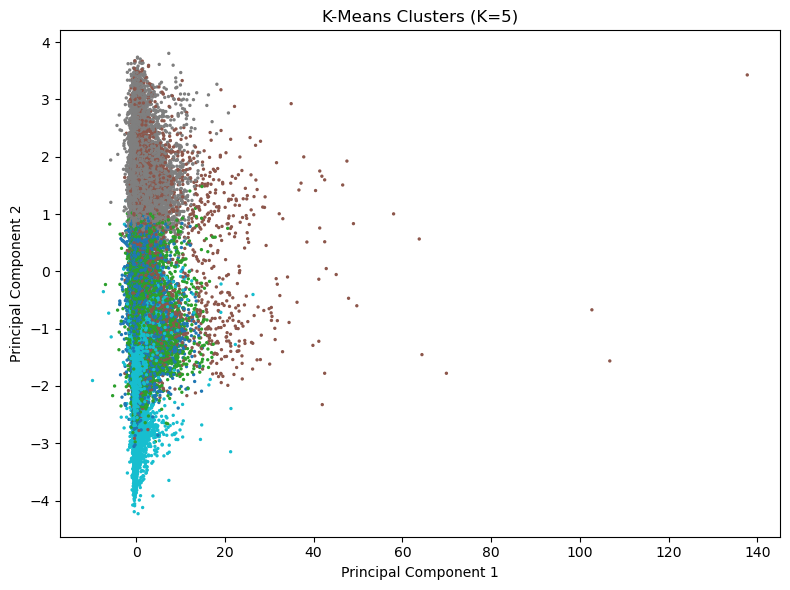

In [156]:
# Visualize the clusters using PCA

labels, centroids = kmeans_implementation(scaled_features, k=5)

pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_features)

plt.figure(figsize=(8, 6))
plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=2)
plt.title("K-Means Clusters (K=5)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()



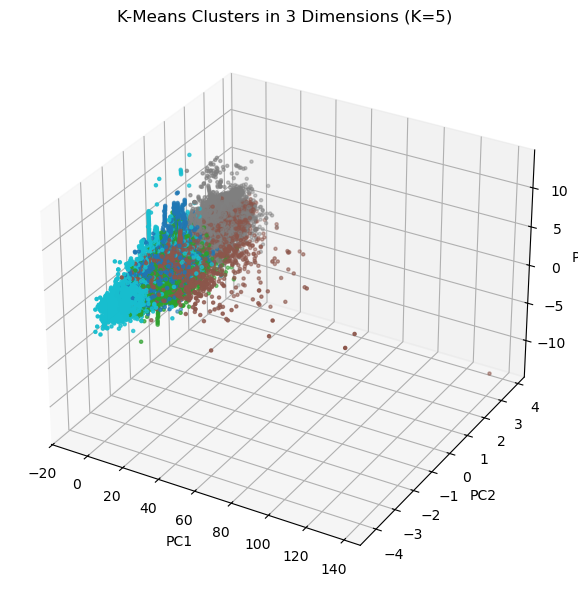

In [157]:
# Let's try it in 3D

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  


pca = PCA(n_components=3)
reduced = pca.fit_transform(scaled_features)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    reduced[:, 0], 
    reduced[:, 1], 
    reduced[:, 2],
    c=labels,
    cmap='tab10',
    s=5
)
ax.set_title("K-Means Clusters in 3 Dimensions (K=5)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.tight_layout()
plt.show()

In [158]:
# Print percentage of points in each cluster

unique, counts = np.unique(labels, return_counts=True)
cluster_distribution = dict(zip(unique, counts))
total_points = len(labels)
for cluster, count in cluster_distribution.items():
    percentage = (count / total_points) * 100
    print(f"Cluster {cluster}: {count} points ({percentage:.2f}%)")

Cluster 0: 62361 points (21.93%)
Cluster 1: 66333 points (23.33%)
Cluster 2: 38174 points (13.43%)
Cluster 3: 97261 points (34.21%)
Cluster 4: 20186 points (7.10%)


In [159]:
# Print percentage of points in each cluster for sklearn implementation
kmeans = KMeans(n_clusters=5, random_state=0)
labels_sklearn = kmeans.fit_predict(scaled_features)
unique_sk, counts_sk = np.unique(labels_sklearn, return_counts=True)
cluster_distribution_sk = dict(zip(unique_sk, counts_sk))
total_points_sk = len(labels_sklearn)
for cluster, count in cluster_distribution_sk.items():
    percentage = (count / total_points_sk) * 100
    print(f"Cluster {cluster}: {count} points ({percentage:.2f}%)")

Cluster 0: 20200 points (7.10%)
Cluster 1: 48678 points (17.12%)
Cluster 2: 115031 points (40.46%)
Cluster 3: 42284 points (14.87%)
Cluster 4: 58122 points (20.44%)
